In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import os
import re

from tqdm import tqdm
from scapy.all import rdpcap
from pipelinetools import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

In [2]:
def load_and_merge_traces(folder):
    merged_traces = {}

    for filename in sorted(os.listdir(folder)):
        match = re.match(r'website_(\d+)_processed\.npz$', filename)
        if not match:
            continue

        website_id = int(match.group(1))
        file_path = os.path.join(folder, filename)

        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            if website_id in merged_traces:
                raise ValueError(f"Duplicate website_id {website_id} found.")
            merged_traces[website_id] = data[website_id]

    return merged_traces

In [35]:
data_dir = "/Users/michaelwrana/Documents/fia-analysis/pcap_analysis/new_dataset/"
traces = load_and_merge_traces(data_dir)

In [ ]:
#load data from .npz
# file_ids = [0, 20, 30, 40, 50, 60, 70, 80, 90]
file_ids = 100
traces = {}  
print(np.__version__)

for i in range(file_ids):
    #front - t1
    # out_file = f"/Users/anhelinabodak/Desktop/mnndn/mnndn-scripts/defenses/front/results/front_t1_npz/website_{i}_front_t1.npz"

    #front - t2
    # out_file = f"/Users/anhelinabodak/Desktop/mnndn/mnndn-scripts/defenses/front/results/front_t2_npz/website_{i}_front_t2.npz"
    
    # #regulator
    # out_file = f"/Users/anhelinabodak/Desktop/mnndn/mnndn-scripts/defenses/RegulaTor-main/regulator_npz/website_{i}_processed.npz"
    
    # #tamaraw
    out_file = f"/Users/anhelinabodak/Desktop/mnndn/mnndn-scripts/defenses/tamaraw/results/tamaraw_npz/website_{i}.npz"
    
    # #wtfpad 
    # out_file = f"/Users/anhelinabodak/Desktop/mnndn/mnndn-scripts/defenses/wtfpad/results/histos_rcv_npz/site_{i}_wtfpad_padded.npz"

    with open(out_file, 'rb') as f:
        traces_one_at_a_time = pickle.load(f)
        traces[i] = traces_one_at_a_time[i] 

    # print(len(traces))

    # print(len(traces[0][1]))

In [24]:
traces_kfp = process_traces(traces, 'kfp')

100%|██████████| 100/100 [27:12<00:00, 16.32s/it]  


In [ ]:
X, y = traces_to_xy(traces_kfp)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.19, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.55, random_state=42)

model = RandomForestClassifier(n_jobs=2, n_estimators=100, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
score = metrics.accuracy_score(y_val, y_pred)

print("k-Fingerprinting Test Accuracy: " + str(score))

k-Fingerprinting Test Accuracy: 0.4425


In [7]:
with open("importances", 'wb') as f:
    pickle.dump(model.feature_importances_, f)

In [8]:
from kfp_extraction import extract_features
tuple_format = [(abs(packet),np.sign(packet)) for packet in traces[0][0]]
tags = extract_features(tuple_format, return_tags=True)
tags_list = tags.split(',')

In [9]:
feature_names = tags_list #+ ["no label"] * 125
print(len(feature_names))
print(feature_names)
with open("importances", 'rb') as f:
    importances = pickle.load(f)

2058
['max_in_interarrival', 'max_out_interarrival', 'max_total_interarrival', 'avg_in_interarrival', 'avg_out_interarrival', 'avg_total_interarrival', 'std_in_interarrival', 'std_out_interarrival', 'std_total_interarrival', '75th_percentile_in_interarrival', '75th_percentile_out_interarrival', '75th_percentile_total_interarrival', '25th_percentile_in_times', '50th_percentile_in_times', '75th_percentile_in_times', '100th_percentile_in_times', '25th_percentile_out_times', '50th_percentile_out_times', '75th_percentile_out_times', '100th_percentile_out_times', '25th_percentile_total_times', '50th_percentile_total_times', '75th_percentile_total_times', '100th_percentile_total_times', 'in_count', 'out_count', 'total_count', 'in_count_in_first30', 'out_count_in_first30', 'in_count_in_last30', 'out_count_in_last30', 'std_out_concentration', 'avg_out_concentration', '50th_out_concentration', 'min_out_concentrations', 'max_out_concentrations', 'avg_count_per_sec', 'std_count_per_sec', '50th_cou

Text(0, 0.5, 'Mean decrease in impurity')

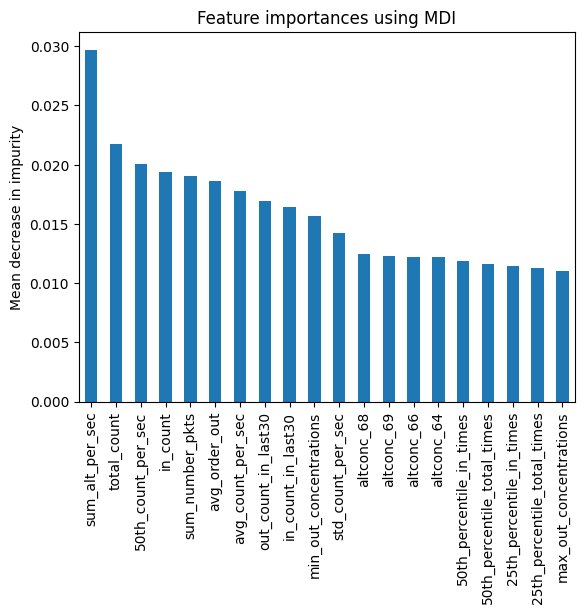

In [10]:
forest_importances = pd.Series(reversed(np.sort(importances)[-20:]), index=reversed([feature_names[i] for i in np.argsort(importances)[-20:]]))
                                                                 
fig, ax = plt.subplots()                                                              
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [ ]:
# avg_order_out: average number of outgoing packets between each incoming packet
# 75th_percentile_out_interarrival: 75th percentile of outgoing packets' interarrival times
# sum_number_pkts: 2 * total number of packets
# std_count_per_sec: standard deviation of the number of packets per second
# in_count: number of incoming packets

# no label: related to packet concentration and ordering features

In [15]:
#importances for a trace used in tuple_format 
feature_vector = extract_features(tuple_format) 
count = 0
conc_count, altconc_count, alt_per_sec_count, =  0, 0, 0 
# per_sec_count = 0
top_indices = np.argsort(importances) 
for idx in reversed(top_indices):
    name = feature_names[idx]
    value = feature_vector[idx]
    print(f"Feature index {idx:<3} | Name: {name:<15} | Value: {value}")
    # count+=1
    if name.startswith("conc"):
        conc_count+=1
    # if name.startswith("per_sec"):
    #     per_sec_count+=1
    elif name.startswith("altconc"):
        altconc_count+=1
    elif name.startswith("alt_per_sec"):
        alt_per_sec_count+=1
        # print(f"Feature index {idx:<3} | Name: {name:<15} | Value: {value}")
    else:
        count+=1
print(f'others count: {count}\n'
      f'conc count: {conc_count}\n'
    #   f'per_sec count: {per_sec_count}\n'
      f'alt_conc count: {altconc_count}\n'
      f'alt_per_sec count: {alt_per_sec_count}\n')
print(f'Sum: {count + conc_count + altconc_count + alt_per_sec_count}')

Feature index 38  | Name: 50th_count_per_sec | Value: 10687.13199331559
Feature index 24  | Name: in_count        | Value: 30950
Feature index 37  | Name: std_count_per_sec | Value: 10606.655730495497
Feature index 51  | Name: sum_number_pkts | Value: 73960
Feature index 47  | Name: sum_alt_concentration | Value: 6030
Feature index 48  | Name: sum_alt_per_sec | Value: 36980
Feature index 29  | Name: in_count_in_last30 | Value: 24
Feature index 26  | Name: total_count     | Value: 36980
Feature index 36  | Name: avg_count_per_sec | Value: 18558.831179321485
Feature index 25  | Name: out_count       | Value: 6030
Feature index 35  | Name: max_out_concentrations | Value: 18133.645936981757
Feature index 32  | Name: avg_out_concentration | Value: 3.2612222823147645
Feature index 82  | Name: altconc_9       | Value: 137
Feature index 45  | Name: in_percentage   | Value: 0.8369388858842618
Feature index 30  | Name: out_count_in_last30 | Value: 6
Feature index 126 | Name: altconc_53      | Va